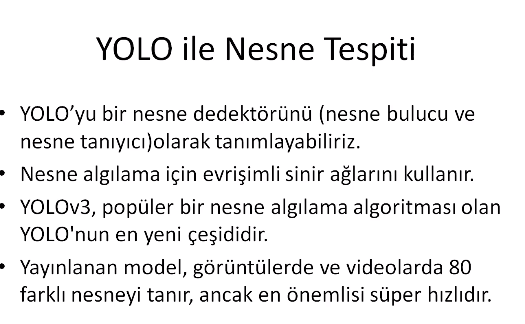

In [ ]:

#importing libraries
import cv2
import argparse
import numpy as np
import pytesseract as py
import pandas as pd
import utils.logger as logger

'''
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True,
                help = 'path to input image')
args = ap.parse_args()
'''

#Using YOLO-V3 

def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

 
#reading the image file
image = cv2.imread('images/repo3.jpg')

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

classes = None

with open('yolov3-classes.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

net = cv2.dnn.readNet('model/yolov3_6000.weights', 'cfg/yolov3-custom.cfg')

blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([round(x), round(y), round(w), round(h)])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)



#----------------------------OCR-------------------------------------------------------------------------



#cropping detected objects and passing into tesseract OCR
A = []
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    crop_img = image[y:y+h, x:x+w]
    cv2.imwrite("Crop/crop__" + str(i) + ".jpg",crop_img)
    # grayscale region within bounding box
    gray = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
    # resize image to three times as large as original for better readability
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    # perform gaussian blur to smoothen image
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # threshold the image using Otsus method to preprocess for tesseract
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #perfrom bitwise not to flip image to black text on white background
    roi = cv2.bitwise_not(thresh)
    #saving the roi regions
    cv2.imwrite("Crop/roi__" + str(i) + ".jpg",roi)
    #passing to tesseract
    c = py.image_to_string(roi, config = '--oem 3')
    A.append(c)



#Splitting elements of A

B =[]
N = len(A)
for i in range(N):
    a = A[i].split('\n')
    B.append(a)




# Conv into dictionary

#declaring the dict key values
K = ["Test Name", "Unit", "Reference Value", "Value"]
Data = dict(zip(K,B))


#Creating a Dataframe
Y = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in Data.items() ]))


#Exporting to CSV 
Y.to_csv (r'out_csv/cust_ocr5.csv', index = False, header=['Test Name', 'Unit', 'Reference Value', 'Value'])




#------------------------for validating crop images---------------------
'''
img = cv2.imread('Crop/crop__1.jpg')

b = py.image_to_string(img,config='--oem 3')

# grayscale region within bounding box
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # resize image to three times as large as original for better readability
gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    # perform gaussian blur to smoothen image
blur = cv2.GaussianBlur(gray, (5,5), 0)
    #cv2.imshow("Gray", gray)
    #cv2.waitKey(0)
    # threshold the image using Otsus method to preprocess for tesseract
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
cv2.imshow("Otsu Threshold", roi)
cv2.waitKey(0)

        # perfrom bitwise not to flip image to black text on white background
roi = cv2.bitwise_not(thresh)
        # perform another blur on character region

    
           
text = py.image_to_string(roi, config='--oem 3')
'''















